In [1]:
import pandas as pd
import numpy as np
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn 
import pingouin as pg
import scipy.stats as st
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [416]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#Création de fonction 
#Fonction pour faire une matrice de confusion
def make_cf(test_y, y_pred): 
    cf = confusion_matrix(test_y, y_pred)
    plt.matshow(cf,cmap = plt.cm.GnBu)

    for (i, j), z in np.ndenumerate(cf):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')

    plt.title("Matrice de Confusion pour un seuil de 0.5 \n")
    plt.colorbar()
    plt.ylabel('Vraies valeurs')
    plt.xlabel('\n Valeurs prédites');
    plt.show()

#Fonction pour faire les densités de score    
def make_density_proba(prob_pred,y_pred):
    df = {'proba':prob_pred,'approve':test_y,'pred':y_pred}
    df=pd.DataFrame(data=df)
    ax = sns.kdeplot(df[df['approve'] == 1]['proba'],shade=True, label="1")
    sns.kdeplot(df[df['approve'] == 0]['proba'], shade=True, ax=ax,label="0",color="darkseagreen")
    ax.plot([0.5, 0.5], [0, 2.5], '--', color="black",label="seuil de prédiction")
    ax.set_title("Distribution des scores pour les deux classes")
    ax.legend(); 
 
#Fonction pour faire courbe ROC et courbe rappel précission
def make_roc_pr(prob_pred):
    plt.figure(figsize=(12,4))
    #  Courbe ROC
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = metrics.roc_curve(test_y, prob_pred)
    r_auc_reg = metrics.roc_auc_score(test_y, prob_pred)
    plt.plot(fpr,tpr,color="darkcyan",label="Courbe ROC, AUC=%.5f" % r_auc_reg )
    plt.xlabel('Faux positif')
    plt.ylabel('Vrai positif')
    plt.legend()
    #  Courbe Rappel Précision
    plt.subplot(1, 2, 2)
    lr_precision, lr_recall, _ = precision_recall_curve(test_y, prob_pred)
    lr_f1, lr_auc_reg = f1_score(test_y, y_pred), auc(lr_recall, lr_precision)
    plt.plot(lr_recall, lr_precision,color="darkcyan", label='Rappel-Précision, PR-AUC=  %.5f' %lr_auc_reg)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()    

# I. Introduction et motivations

### Objectif Global :
Le triple objectif de ce projet est : 
- La prise en main/découverte de Python.
- L'étude de différents outils de Machine Learning.
- L'étude des performances de prédiction de nos outils sur des données.

Pour ce faire, nous avons choisi d'appliquer notre travail sur un problème social majeur : La discrimination sur le marché de l'immobilier. La recherche d'une base de données sur ce sujet a été compliquée. Ainsi, nous nous sommes concentrés sur la question de l'octroi ou non d'un prêt immobilier, grâce à une base de données receuillie dans les années 90 par la réserve féderale de Boston. L'intérêt pour nous est de savoir si l'éthnie d'un demandeur de prêt immobilier peut impacter l'octroi de son crédit.
Beaucoup d'études ont été réalisées sur ce sujet dans les années 70 à 90 aux États-Unis. Il peut être intéressant de comparer nos résultats à ces données.


#### Découverte des variables de la base de données :

Pour commencer, découvrons la composition de notre base de données. La variable que nous cherchons à expliquer est **approve**, une variable binaire qui indique si l'individu a obtenu ou non son prêt. Au total, nous avons 19 variables explicatives, dont 11 catégorielles (ou binaires) et 8 quantitatives. 

Nous avons des variables qui permettent de décrire le prêt demandé, comme la durée de remboursement du prêt (variable quantitative **term**), le montant du prêt (variable quantitative **loanamt**). 

Nous avons des variables qui nous permettent de connaître le demandeur et sa situation : son sexe (variable factorielle **sex**), s'il a été à l'université (variable binaire **university**), s'il est marié (variable bianire **married**), le nombre de personnes qu'il a à sa charge (variable quantitative **dep**), son revenu mensuel et celui de son conjoint (variable quantitative **atotinc**, **cototinc**), ainsi que son expérience professionnelle en années (**exper**).

Pour finir, nous avons également à disposition des variables permettant de définir le profil et antécedant financier du demandeur de prêt. En effet, nous avons le ratio des frais de logement, pourcentage total sur revenu (**hrat**), les autres dépenses, en pourcentage du revenu total (**obrat**). Nous avons un score de solvabilité allant de 0 à 9 (**score**), et enfin une variable indiquant s'il n'y a pas d'historique de non-remboursement de crédit à la consommation, une autre indiquant s'il y a eu 1 ou 2 retards de paiement, et une indiquant s'il y a eu plus de deux retards de paiement (variables binaires **delinq**, **morperf**, **mortlat1**, **mortlat2**).

In [3]:
data = pd.read_csv('Loan_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 20 columns):
approve       1989 non-null int64
loanamt       1989 non-null int64
term          1989 non-null float64
caution       1989 non-null int64
atotinc       1989 non-null int64
cototinc      1989 non-null float64
hrat          1989 non-null float64
obrat         1989 non-null float64
sex           1974 non-null object
university    1989 non-null int64
race          1989 non-null object
married       1986 non-null float64
dep           1986 non-null float64
exper         1989 non-null int64
self          1989 non-null int64
score         1980 non-null float64
delinq        1989 non-null int64
mortperf      1989 non-null int64
mortlat1      1989 non-null int64
mortlat2      1989 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 310.9+ KB


Notre base de données possède quelques valeurs manquantes que nous pourrions traiter pour les remplacer par la moyenne ou médiane, ou encore par des méthodes d'apprentissage supervisé. Cependant, nous considérons avoir suffisament de données pour supprimer les lignes comportant des valeurs manquantes. 

In [4]:
data.isnull().sum()
data1=data.dropna() #Suppression de 26 lignes
data1.shape

(1963, 20)

# Etape 1: Visualisation des données pour la detection d'outlier

Avant une quelconque analyse de nos données, nous devons nous assurer de sa qualité. Ainsi, la première étape est la détection d'outlier qui peut passer par la distribution des données. (Nous avons retiré celle-ci du NoteBook par soucis de concision, car sur nos données elles apportent les mêmes informations que les boites à moustaches ci-dessous. En effet, nous n'avions pas de valeurs aberrantes pour les variables factorielles.).  

In [5]:
#Création d'une nouvelle table contenant seulement les variables quantitatives
col = [ 1, 2, 4, 5, 6, 7, 12, 13]
data_quanti = data1.iloc[: , col]

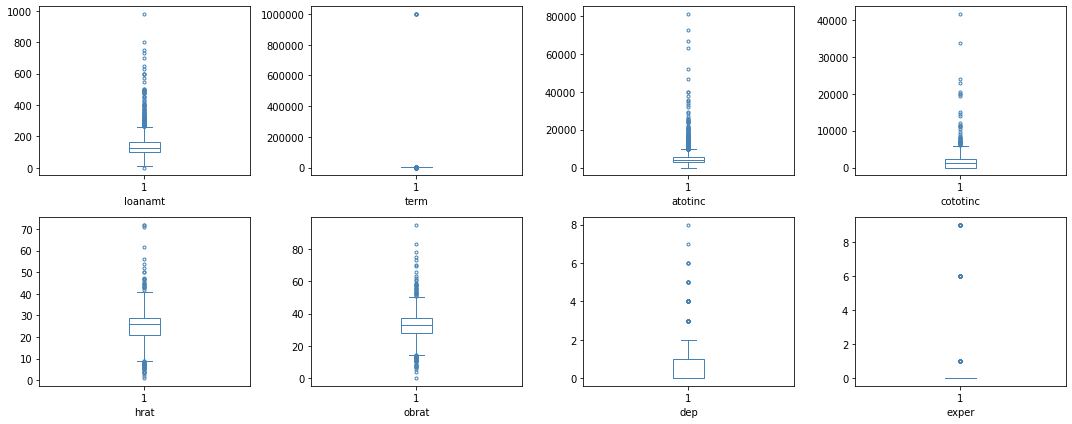

In [6]:
#Boxplot pour les variables quatitatives
c = 'steelblue'
blue_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor='w'),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c,marker="."),
             'medianprops': dict(color=c),
             'whiskerprops': dict(color=c)}

plt.close()
plt.figure(figsize=(15,6))
for i in np.arange(start=0,stop=data_quanti.shape[1]):
    plt.subplot(2, 4, i+1)
    plt.boxplot(data_quanti.iloc[:,i],**blue_dict)
    plt.xlabel(data_quanti.columns[i])
plt.tight_layout()
plt.show()

Les boites à moustache nous permettent de détecter des valeurs extrêmes ou aberrantes pour des variables quantitatives. On remarque notamment pour la variable **term** des valeurs qui semblent aberrantes. En effet, pour 3 individus, le nombre de mois demandé pour rembrouser le crédit immobilier est de 1 000 000. On peut supposer que la valeur possède des 0 en trop, ou qu'il s'agisse de cas extrêmes. Nous préférons donc les exclure de la base de données. En l'absence des ces valeurs extrêmes, le nombre de mois maximum demandé est de 480. Pour les autres variables comme **loanamt** et **atotinc** par exemple, il y a beaucoup de valeurs au dessus de la boite à moustache. Cependant, nous ne pouvons pas les qualifier d'abérrantes car elles semblent réalistes et ne sont pas des cas isolés.

In [7]:
#Suppression d'outliers
data_quanti=data_quanti[(data_quanti["term"]<500)] 
data2=data1[(data1["term"]<500)] 
#data2.shape

# Etape 2: Analyse Univariée

Pour tout travail nécessitant une base de données, il est primordial de procéder à une analyse univariée de nos données afin de connaitre la population que nous avons.

## 2.1. Analyse univariée des variables quantitatives

Dans le jeu de données « Loan_data.csv », il y a 8 variables quantitatives (loanmt, term, atotinc, cototinc, hart, obrat, dep et exper). Pour chacune de ces variables, nous présentons les paramètres de tendances centrales (Moyenne, Maximum, Minimum, quantiles (25%, 50% et 75%)) et l’écart-type comme indicateur de dispersion.

### 2.1.1. Parametres des tendances centrales et indicateur de dispersion.

In [8]:
# Tableau des indicateurs
data_quanti.describe()

,loanamt,term,atotinc,cototinc,hrat,obrat,dep,exper
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,143.493619,340.835120,5160.489535,1552.738397,24.850373,32.452318,0.771822,0.207759
std,80.920571,64.770711,5206.785465,2373.606577,7.085904,8.226071,1.105979,0.991394
min,2.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,100.000000,360.000000,2875.000000,0.000000,21.000000,28.000000,0.000000,0.000000
50%,127.000000,360.000000,3794.000000,1152.000000,25.900000,33.000000,0.000000,0.000000
75%,165.000000,360.000000,5583.000000,2417.000000,29.000000,37.000000,1.000000,0.000000
max,980.000000,480.000000,81000.000000,41667.000000,72.000000,95.000000,8.000000,9.000000


D'après les résultats du tableau des indicateurs ci-dessus, nous remarquons que le montant du prêt immobilier de nos individus est compris entre 2,000.00 et 980,000.00 dollars US. Il y a donc une très forte dispersion des montants demandés. La moyenne étant de 143,493.62 dollars US, elle est au dessus de la médiane de 16,000 dollars, ce qui indique que la moyenne est influencée par les personnes demandant de gros crédits. 

La durée moyenne du prêt est de 341 mois environ, et les durées minimale et maximale du prêt immobilier sont respectivement de 6 et 480 mois. Cette fois, la moyenne est tirée par des durées de remboursement plus faibles, car la médiane est de 360 mois. 

Le revenu moyen mensuel total des emprunteurs est de 5,160.49 dollars US, lui aussi est largement supérieur à la médiane. Ainsi, dans notre échantillon il y a des hauts revenus qui se détachent. Ce qui rejoint les boites à moustache vues précédemment. 


Le ratio des frais de logement en pourcentage par rapport au revenu total est de 24.85, c'est-à-dire que les frais de logement sont 24 fois plus élévés que le revenu total des emprunteurs. Pour les autres variables, le tableau suffit.

### 2.1.2. Représentation graphique des variables quantitatives

**Graphiques : Distribution des variables**

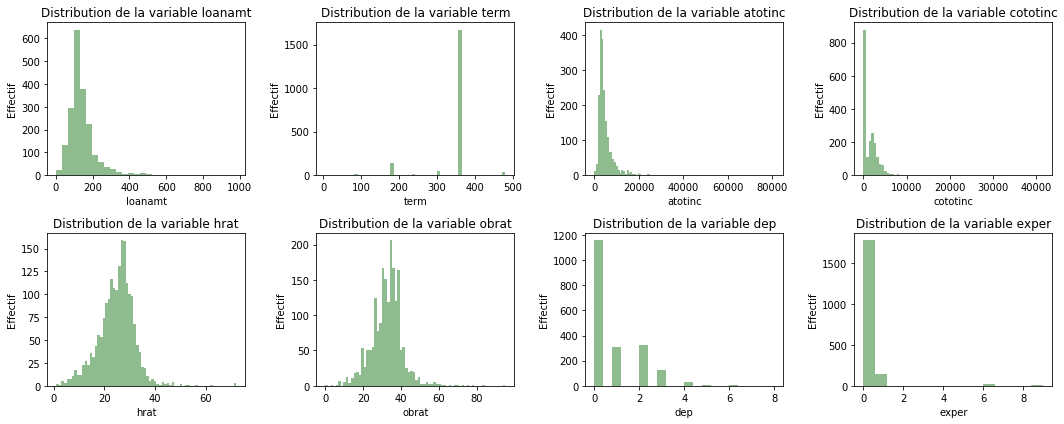

In [9]:
# Graphique: Distribution
b=[30,50,100,70,70,70,20,15]
plt.figure(figsize=(15,6))
for i in np.arange(start=0,stop=data_quanti.shape[1]):
    plt.subplot(2, 4, i+1)
    plt.hist(data_quanti.iloc[: , i], bins=b[i], color='darkseagreen')
    plt.xlabel(data_quanti.columns[i])
    plt.ylabel('Effectif')
    plt.title('Distribution de la variable ' + data_quanti.columns[i])
plt.tight_layout()
plt.show()


Les graphiques ci-dessus permettent de mieux visualiser comment se répartissent nos variables quantitatives, et notamment l'influence des hauts revenus ou des gros montants demandés.

## 2.2.  Analyse Univarée des variables qualitatives

Dans la base de données "Loan_data.csv", nous avons 12 variables qualitatives que nous allons analyser en présentant un graphique pour visualiser leur part dans la base de donnnées et en donnant un tri à plat de chaque variable.

### 2.2.1. Tri à plat et graphique des variables qualitatives.

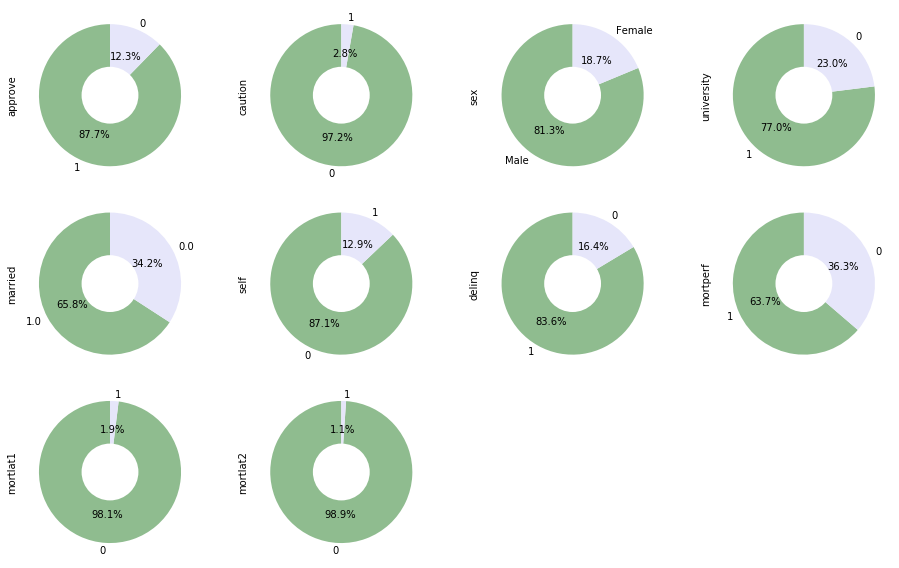

In [10]:
#Pie des varibales qualitatives binaires
col1=[0,3,8,9,11,14,16,17,18,19]
j=1
plt.figure(figsize=(13,8))
for i in col1:
    plt.subplot(3, 4, j)
    j=j+1
    data2.iloc[:,i].value_counts().plot.pie(subplots=True ,
                                                 autopct='%1.1f%%',
                                                 startangle=90,
                                                 colors = ['darkseagreen','lavender'])
    centre_circle = plt.Circle((0,0),0.4,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle) 
plt.tight_layout() 
plt.show()

Sur l'ensemble de nos emprunteurs, 87.7% ont obtenus leur demande de prêt, 36.3% ont déjà eu un paiement hypothécaire en retard (**mortperf**). De ce fait, nous pouvons déjà penser qu'avoir un retard de paiement hypothécaire n'est pas un critère rédibitoire dans l'obtention d'un prêt immobilier. 65.7% de nos individus sont mariés. Or, nous savons qu'un mariage augmente les revenus d'un ménage et peut faciliter l'obtention de son crédit.

**Remarque :** Notre variable à expliquer **approve** n'est pas équilibrée, nos algorithmes peuvent donc avoir du mal à apprendre efficacement et à détecter les personnes dont le prêt a été refusé. Il faudra en prendre compte cela dans la suite.

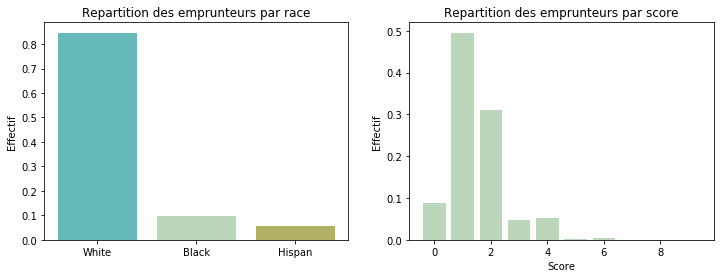

In [11]:
# Bar plot de la variable race 
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.bar(data2['race'].value_counts(normalize=True).index, data2['race'].value_counts(normalize=True).values ,alpha=0.6, color=['darkcyan','darkseagreen', 'olive'], width=0.8)
plt.ylabel('Effectif')
plt.title('Repartition des emprunteurs par race')

# Bar plot de la variable score
plt.subplot(1, 2, 2)
plt.bar(data2['score'].value_counts(normalize=True).index, data2['score'].value_counts(normalize=True).values, alpha=0.6,color=['darkseagreen'])
plt.ylabel('Effectif')
plt.xlabel('Score')
plt.title('Repartition des emprunteurs par score')
plt.show()

La population noire et hispanique est très peu représentée, respectivement 0.09% et 0.05% des observations.

# Etape 3 : Analyse Bivariée

Nous pouvons à présent procéder à une analyse bivariée de nos données. Cette étape est essentielle, elle permet de repérer des liaisons entre les variables. Or, nous savons que des corrélations fortes entre des variables peuvent biaiser les résultats de certains modèles (notamment de la régression logsitique), d'où l'importance de cette étape. 


## 3.1. Etude de liaison entre les varaibles quantitatives.

Dans cette partie du document, nous étudions la liaison entre les variables quantitatives (loanmt, term, atotinc, cototinc, hart, obrat, dep et exper). Pour ce faire, nous utiliserons comme indicateurs la matrice des coefficients de corrélation, ensuite nous réaliserons le graphique du nuage de points pour les couples de variables, afin de visualiser les liaisons qui ne seraient pas linéaires entre des couples des variables, et enfin, pour confirmer ces potentielles liaisons nous réaliserons des tests statistiques.

### 3.1.1. Matrice des coefficients de correlations.

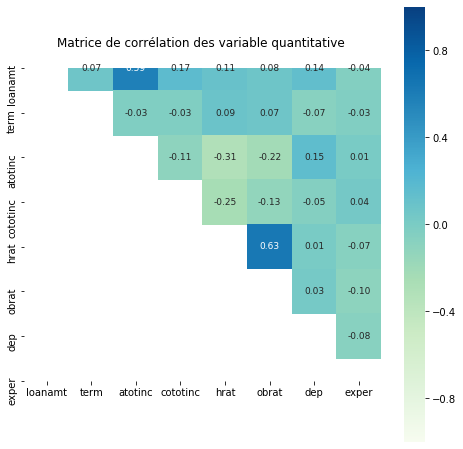

In [12]:
#Matrice de corrélation
col = [ 1, 2, 4, 5, 6, 7, 12, 13]
plt.figure(figsize=(8,8))
masque  =  np.tril(data2.iloc[: , col].corr())
sns.heatmap(data2.iloc[: , col].corr(),annot=True,annot_kws={"size": 9}, vmin=-1, vmax=1,fmt='.2f',cmap= 'GnBu' ,square=True,mask = masque)
plt.title('Matrice de corrélation des variable quantitative \n')
plt.show()

D'après la matrice de corrélation ci-dessus, nous remarquons qu'il y a à priori une forte corrélation positive entre les variables "loanamt" et "atotinc". Ce qui n'est pas surprenant car le montant du prêt immobilier dépend généralement du revenu mensuel total de la personne demandant le prêt. Ensuite, il y a à priori une forte corrélation positive entre les variables "obrat" et "hrat". Ainsi, le pourcentage des dépenses de logement en fonction du revenu total, et le pourcentage des autres dépenses en fonction du revenu total varient dans le même sens.  

### 3.1.2. Graphique pour visualiser la liaison entre les variables quantitatives :

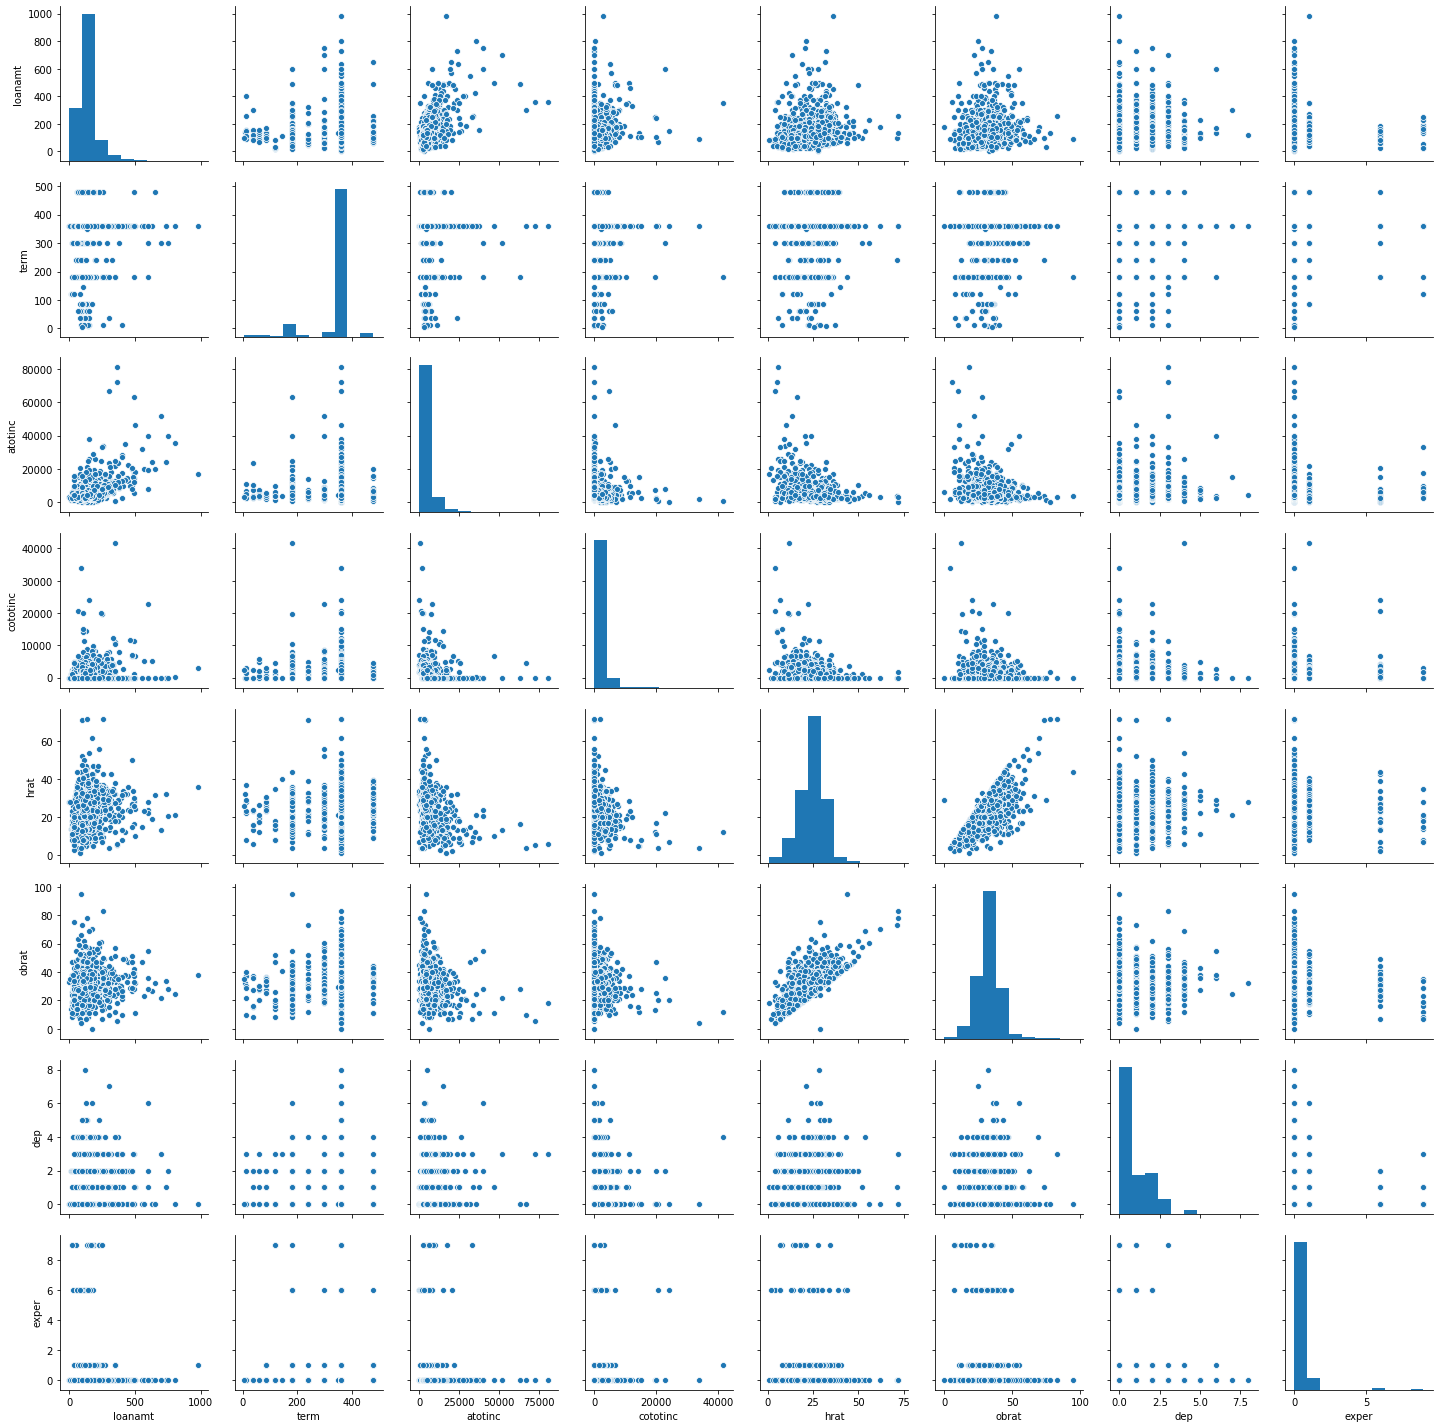

In [13]:
#Attention long a executer
sns.pairplot(data2.iloc[: , col]);

### 3.1.3. Tests statitisques pour confirmer les liaisons
Pour confirmer les liaisons existant entre les variables ci-dessous, nous réalisons le test du coefficient de corrélation linéaire de Pearson à 0.

In [14]:
# Tests statistiques pour confirmer la liaison entre les variables
# Matrice des p-values (pearson)
data2.iloc[:,col].rcorr(stars=False, decimals=4)

,loanamt,term,atotinc,cototinc,hrat,obrat,dep,exper
loanamt,-,0.0038,0.0000,0.0000,0.0000,0.0008,0.0000,0.0475
term,0.0654,-,0.2606,0.2269,0.0000,0.0028,0.0017,0.1523
atotinc,0.5858,-0.0254,-,0.0000,0.0000,0.0000,0.0000,0.7100
cototinc,0.17,-0.0273,-0.1053,-,0.0000,0.0000,0.0193,0.1183
hrat,0.1069,0.0924,-0.3074,-0.2471,-,0.0000,0.5215,0.0032
obrat,0.0757,0.0676,-0.221,-0.1308,0.633,-,0.2129,0.0000
dep,0.1387,-0.0709,0.1499,-0.0529,0.0145,0.0282,-,0.0007
exper,-0.0448,-0.0324,0.0084,0.0353,-0.0665,-0.0957,-0.0765,-


Dans le tableau ci-dessus, nous trouvons les p-values de pearson dans la partie supérieure de la matrice. En effet, les résultats montrent que la variable "loanamt" (le montant du prêt immobilier) est corrélée avec toutes les autres variables au seuil de 5%. La variable "term"(la durée du prêt en terme de mois) est corrélée avec les variables "hrat", "obrat", "dep" et non corrélée avec les variables "atotinc", "cototinc" et "expr". Ce qui signifie que la durée du prêt dépend du ratio des frais de logement de l'emprunteur, de ses autres dépenses et du nombre de personnes à sa charge. Donc, la durée du prêt est liée aux dépenses de l'emprunteur. La variable "expr" (Nombre d'années d'expérience professionnelle) est correlée avec les variables "hrat", "obrat", "loanamt" et "dep".

### 3.1.4. Représentation graphique de la distribution des variables "Atotinc", "hrat", "obrat", "dep" , "exper" et "cototinc" en fonction de la variable "approve"¶

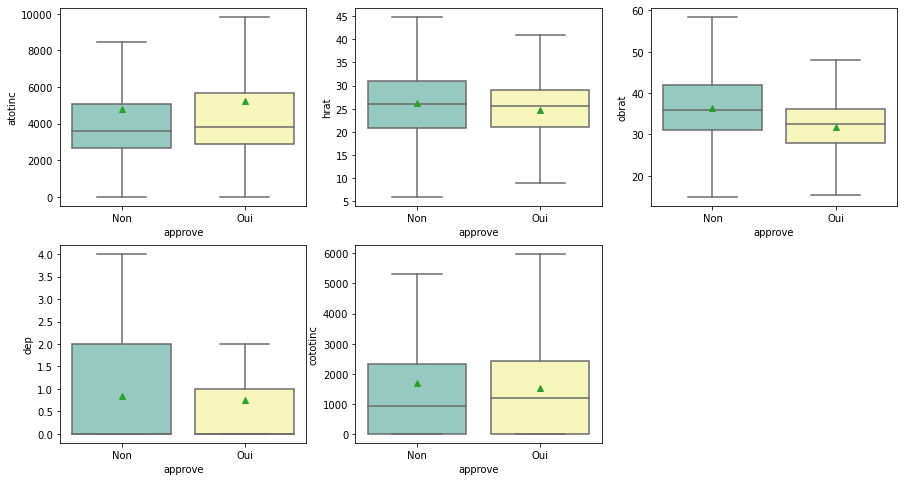

In [31]:
col=["atotinc","hrat","obrat","dep","cototinc"]
j=0
plt.figure(figsize=(15,8))
for i in col:
    j=j+1
    plt.subplot(2, 3, j)
    sns.boxplot(y=data2[i],x=data2["approve"], showfliers=False, showmeans=True,palette="Set3").set_xticklabels(["Non", "Oui"])

## 3.2. Etude de liaison entre les variables qualitatives

Dans cette partie, nous vérifions la liaison qui existe entre la variable dépendante (qui est une variable qualitative dichotomique) et les autres variables qualitatives du jeu de données. Pour ce faire, nous réalisons un test d'indépendance de Khi-deux.


### 3.2.1. Test d'indépendance Khi-deux

In [32]:
Y=["sex","caution","race","university","married","self","delinq","mortperf"]
print("Variable \t Résultat du test \n")
for i in Y:
    cont = data2[["approve", i]].pivot_table(index="approve", columns=i, aggfunc=len).copy()
    cont = cont.astype(int)
    st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
    print(i+":    \t", st_p);

Variable 	 Résultat du test 

sex:    	 0.5546966229433589
caution:    	 0.7188647430377841
race:    	 3.722365099964352e-22
university:    	 0.10168090871083958
married:    	 0.00829790648866826
self:    	 0.08582071930147311
delinq:    	 1.5699404500732212e-24
mortperf:    	 0.0016744265549047113


D'après les résultats des tests statistiques réalisés ci-dessus, nous remarquons que la variable "approve" est significativement liée avec les variables "race", "mararied", "delinq" et "mortperf" car les probabilités (p-values) sont inférieures à 5%. Dans ce cas, l'hypothèse nulle est rejetée, c'est-à-dire que les variables ne sont pas indépendantes. Ce qui traduit que l'octroi ou non d'un prêt immobilier dépend de l'ethnie, du statut matrimonial et de l'historique de non-remboursement de crédit à la consommation du démandeur du prêt.

### 3.2.2. Graphique des couples de variables qualitatives significativement liées.


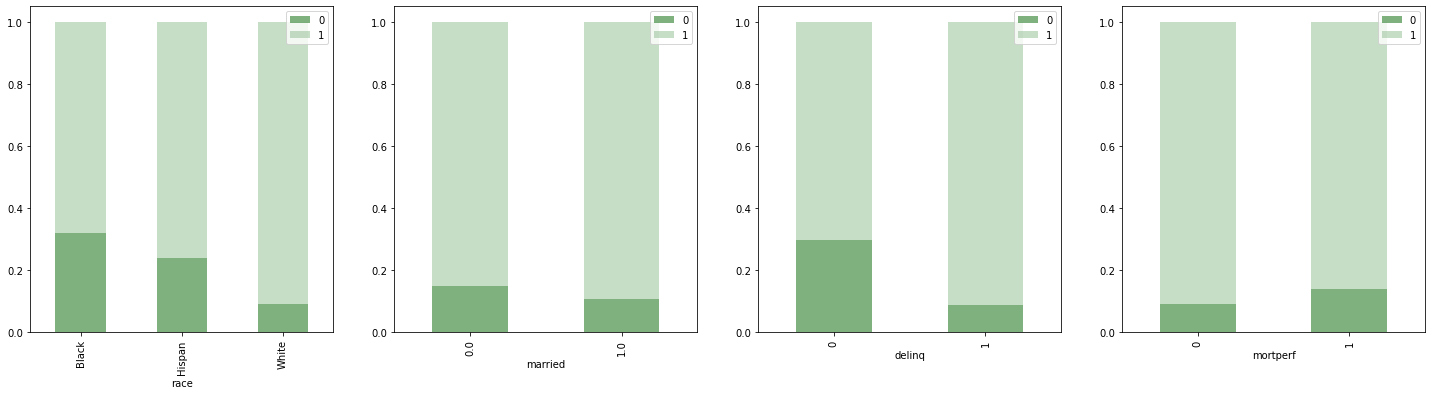

In [33]:
Y=['race','married','delinq','mortperf']
j=1
plt.figure(figsize=(25,6))
for i in Y:  
    plt.subplot(1,4,j)
    pd.crosstab(data2[i], data2['approve'],normalize="index").plot.bar(stacked=True, ax=plt.gca(),alpha=0.5,color=["darkgreen","darkseagreen"]);
    plt.legend(loc='upper right')
    j=j+1

# Etape 4 : Analyse Multivariée

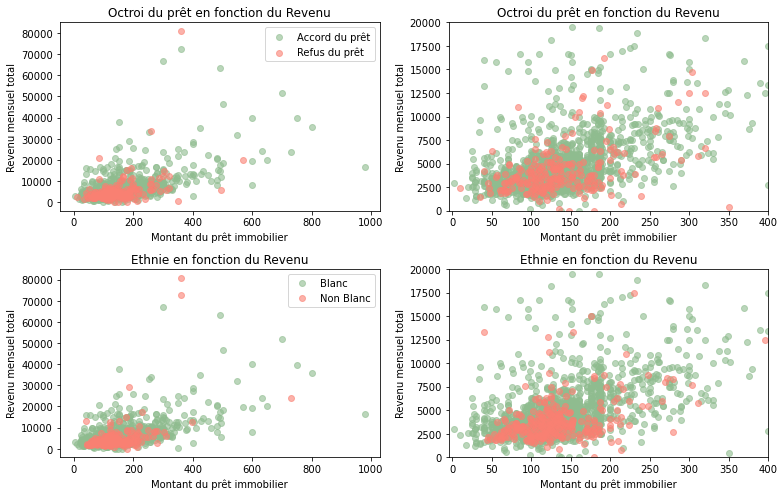

In [34]:
plt.figure(figsize=(11,7))
plt.subplot(2, 2, 1)
plt.scatter(data2[data2["approve"]==1]["loanamt"], data2[data2["approve"]==1]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["approve"]==0]["loanamt"], data2[data2["approve"]==0]["atotinc"],alpha=0.6,c='salmon');
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Octroi du prêt en fonction du Revenu');
plt.legend( ["Accord du prêt", "Refus du prêt"]);
plt.subplot(2, 2, 2)
plt.scatter(data2[data2["approve"]==1]["loanamt"], data2[data2["approve"]==1]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["approve"]==0]["loanamt"], data2[data2["approve"]==0]["atotinc"],alpha=0.6,c='salmon');
plt.axis([-5, 400, -5, 20000])
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Octroi du prêt en fonction du Revenu');

plt.subplot(2, 2, 3)
temp=data2.sort_values("race",ascending=False)
plt.scatter(data2[data2["race"]=="White"]["loanamt"], data2[data2["race"]=="White"]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["race"]!="White"]["loanamt"], data2[data2["race"]!="White"]["atotinc"],alpha=0.6,c='salmon');
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Ethnie en fonction du Revenu');
plt.legend( ["Blanc", "Non Blanc"]);
plt.subplot(2, 2, 4)
plt.scatter(data2[data2["race"]=="White"]["loanamt"], data2[data2["race"]=="White"]["atotinc"],alpha=0.6,c='darkseagreen');
plt.scatter(data2[data2["race"]!="White"]["loanamt"], data2[data2["race"]!="White"]["atotinc"],alpha=0.6,c='salmon');
plt.axis([-5, 400, -5, 20000])
plt.xlabel('Montant du prêt immobilier')
plt.ylabel('Revenu mensuel total')
plt.title('Ethnie en fonction du Revenu');
plt.tight_layout() 

# Etape 5 : Echantillonnage

#### Création des variables dummies

In [15]:
data2 = pd.get_dummies(data2)

#### Echantillonage

In [16]:
data_X,test_X, data_y, test_y = train_test_split(data2.drop(['approve'], axis=1),
                                                 data2["approve"], 
                                                 test_size=0.2, 
                                                 random_state=5, 
                                                 stratify=data2["approve"])

#### Rééquilibrage de la BDD d'entrainement

In [17]:
os = SMOTE(random_state=1)
os_data_X,os_data_y=os.fit_sample(data_X, data_y)
print("Longueur de la nouvelle BDD",len(os_data_X))
print(os_data_y.value_counts())


Longueur de la nouvelle BDD 2748
1    1374
0    1374
Name: approve, dtype: int64


#### Normalisation des données

In [18]:
data_X_scale=preprocessing.scale(os_data_X)

scaler = preprocessing.StandardScaler().fit(data_X_scale)

test_scale_X=scaler.transform(test_X)

In [19]:
data_X_scale = pd.DataFrame(data=data_X_scale, columns=os_data_X.columns)
test_scale_X = pd.DataFrame(data=test_scale_X, columns=os_data_X.columns)

# Etape 6 : Modélisation

Les données étant connues, comprises et sous la bonne forme nous pouvons débuter nos modélisations.

- La Regression Logistique
- Les Arbres de décision
- Les Fôrets Aléatoires

## 1. La Régression Logistique

Notre premier modèle économétrique de classification supervisée : la régression logistique. Nous commençons par un premier modèle comportant toutes des variables explicatives de notre base données. Avant de commenter les résultats obtenus nous allons procéder à une selection de variable car nous constatons que pour certaines vairable les estimations des coefficients ont des p-values non significatifs. Nous allons donc retirer progressivement une a une les variables avec des p-values suppérieures à 0.05. Nous commencerons par les p-values les plus élevées et nous poursuivrons tant que le critère pénalisé BIC diminu, afin de le minimiser.   

In [386]:
logit = sm.Logit(os_data_y, os_data_X.astype(float))
result=logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.396639
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.428    
Dependent Variable: approve          AIC:              2223.9297
Date:               2020-12-06 13:04 BIC:              2354.1395
No. Observations:   2748             Log-Likelihood:   -1090.0  
Df Model:           21               LL-Null:          -1904.8  
Df Residuals:       2726             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
loanamt          0.0013   0.0011   1.1866 0.2354 -0.0008  0.0034
term            -0.0075   0.0008  -8.8177 0.0000 -0.0091 -0.0058
caution      

###  Selection des variables (Amélioration du critère BIC)

La selection de variable par p-value et BIC nous a permit d'exclure du modèle une dizaine de variable. On remarque notamment que des variables comme **loanamt** ou **hrat** ont été exclues du modèle. Or, il s'agit du montant du prêt demandé et du ratio des frais de logement, en pourcentage total sur revenu. Ce résultat est assez surprenant car lorsqu'on pense faire une demande de crédit ces indicateurs financier viennent à l'esprit en premier. De même, savoir si un demandeur de crédit a dejà eu un paiement hypothécaire en retard (**mortperf**) devrait être un déterminant important, pourtant cette variable n'est également pas retenu.

À l'inverse, en ce qui concerne les variables retenues, on constate premièrement que le genre et l'ethnie sont des variables très significative dans ce modèle avec des coeficients importants. Or, ces deux critères ne devrait pas être prit en compte lors d'une demande de crédit. Ceci signifie que a durée de remboursement donné, revenu donné, statut marital donné, les origines du demandeurs de crédit à un impact sur l'octroi de crédit.

On conserve également la durée du prêt (**term**), et le revenu mensuel (**atotinc**). Cependant, le coefficient de cette dernière est très proche de zéro sont impact peut être discutré et sont effet dans le modèle est négatif (-0.0001).


In [387]:
select_data=os_data_X.drop(['hrat','score','exper','self','mortperf','university','mortlat2','loanamt','mortlat1','dep','cototinc'], axis='columns')
select_test=test_X.drop(['hrat','score','exper','self','mortperf','university','mortlat2','loanamt','mortlat1','dep','cototinc'], axis='columns')

logit2 = sm.Logit(os_data_y,select_data.astype(float))
result2=logit2.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.400804
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.422    
Dependent Variable: approve          AIC:              2224.8195
Date:               2020-12-06 13:04 BIC:              2289.9244
No. Observations:   2748             Log-Likelihood:   -1101.4  
Df Model:           10               LL-Null:          -1904.8  
Df Residuals:       2737             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
term            -0.0072   0.0008  -9.0118 0.0000 -0.0088 -0.0057
caution          1.8844   0.5418   3.4781 0.0005  0.8225  2.9463
atotinc      

###  Prédiction - Étude des performances de prédiction

Dans le but de comparer les performances de nos modèles on réalise une matrice de confusion. Or, les résultats de la matrice de confusion ne permettent pas de comparer les résultats entre différentes méthodes, car elle depende du seuil de prédiction (ici 0.5) faire varier ce seuil peut influancer les résultats du nombre de vrais positifs ou vrais négatifs. Or, nous ne voulons pas influencer les résultats obtenus de ce fait on utiliser des métriques comme l'AUC ou la PR-AUC pour faire varier le seuil de 0 à 1 et définir qu'elle est le meilleur modèle sur nos données. 

In [388]:
prob_pred=result2.predict(select_test)
y_pred=(prob_pred>0.5).astype(int)

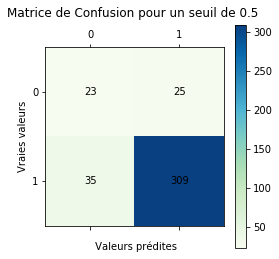

In [404]:
make_cf(test_y, y_pred)

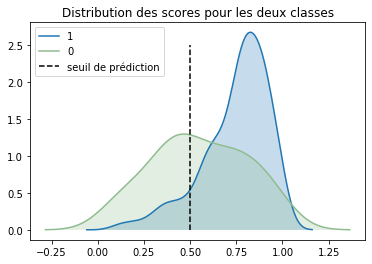

In [412]:
make_density_proba(prob_pred,y_pred)

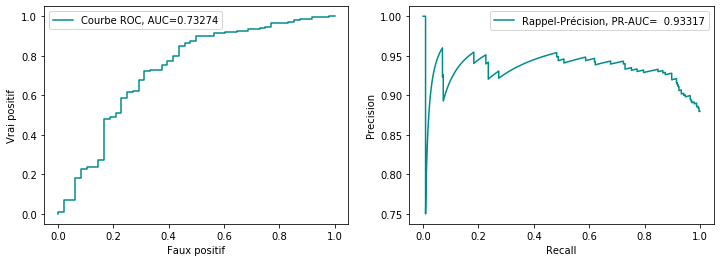

In [413]:
make_roc_pr(prob_pred)    

## 2. Arbre de décision

Vérification de la version de scikit-learn 

In [48]:
print(sklearn.__version__)

0.23.1


#### Instance de l'arbre

Comme pour la régression logistique nous commençons par prendre en compte le maximum d'information en réalisant l'arbre maximal.

In [343]:
#Construction de l'arbre maximal
arbre = DecisionTreeClassifier(random_state=0)
arbre.fit(os_data_X,os_data_y)

DecisionTreeClassifier(random_state=0)

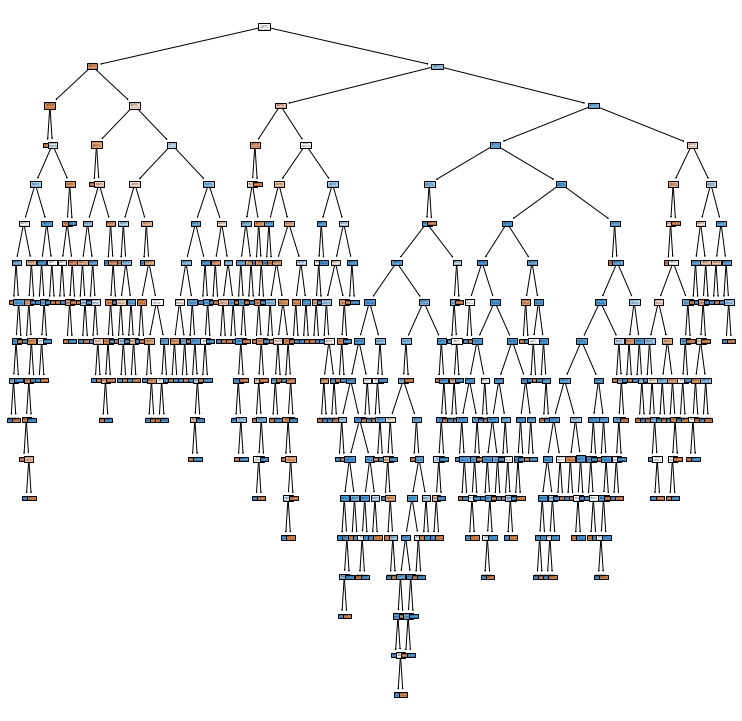

In [344]:
plt.figure(figsize=(13,13))
plot_tree(arbre,feature_names = list(os_data_X.columns),filled=True) 
plt.show()

In [345]:
print('Accuracy (Précision) sur les données d\'apprentissage: ',arbre.score(os_data_X,os_data_y))
print('Accuracy (Précision) sur les données de test :',arbre.score(test_X,test_y))

Accuracy (Précision) sur les données d'apprentissage:  1.0
Accuracy (Précision) sur les données de test : 0.8341836734693877


Or, nous savons que l'arbre maximal fait du surapprentissage. En effet, il prédit parfaitement les données d'apprentissage mais est beaucoup moins performant si on cherche a expliquer de nouvelles observations. Ainsi, il est recommandé d'élaguer notre arbre afin de trouver un rabre qui permettrer d'expliquer aussi bien les données de notre base d'apprentissage que de nouvelles observations.


#### Élagage du coût de la compléxité paramétrique

Pour réaliser cette étape nous utiliserons un paramètre **alpha**, plus se dernier augmente plus la dimension de taille se réduit car une plus grande partie de l'arbre est élagagée. Ainsi, la dernière valeur prise par alpha correspondra au noeud de l'arbre. 
Or, lorsque la valeur d'alpha augmente l'impureté total des feuilles augmentes. Il s'agit donc de trouver le meilleur compromis.

In [346]:
path=arbre.cost_complexity_pruning_path(os_data_X,os_data_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

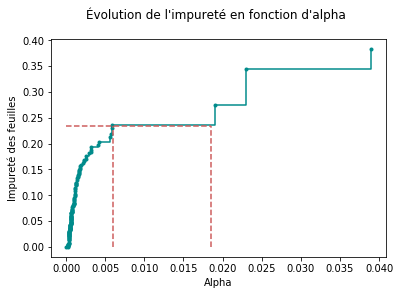

In [347]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='.',color="darkcyan", drawstyle="steps-post")
ax.plot([0.006, 0.006], [0, 0.235], '--', color="indianred")
ax.plot([0.0185, 0.0185], [0, 0.235], '--', color="indianred")
ax.plot([0, 0.0185], [0.235, 0.235], '--', color="indianred")
ax.set_xlabel("Alpha")
ax.set_ylabel("Impureté des feuilles")
ax.set_title("Évolution de l'impureté en fonction d'alpha \n");

Comme nous l'avons expliqué précedement l'augmentation d'alpha implique une augmentation de l'impureté des feuilles de l'arbre. Nous avons pu vérifier cela sur le graphique ci-dessus. Ainsi, nous choisissons le plus grand **alpha** qui induit un coût d'impureté marginal le plus faible. De ce fait nous pouvons prendre un **alpha** compris entre 0.006 et 0.019, les performances obetenus seront les mêmes sur nos données. 

**Remarque :** Nous avions également tenté de choisir l'arbre optimal en faisant varier les paramètres **min_samples_leaf** et **max_depth** de la fonction DecisionTreeClassifier dans des boucles for, et observé l'évolution de l'accurancy. Cependant, cette méthode n'est pas optimale et n'est pas celle recommandée. Nous conservons donc les résultats obtenu par Élagage du coût de la compléxité paramétrique.

Ainsi, pour **alpha=0.0185** nous obtenons l'arbre élagé ci-dessous :


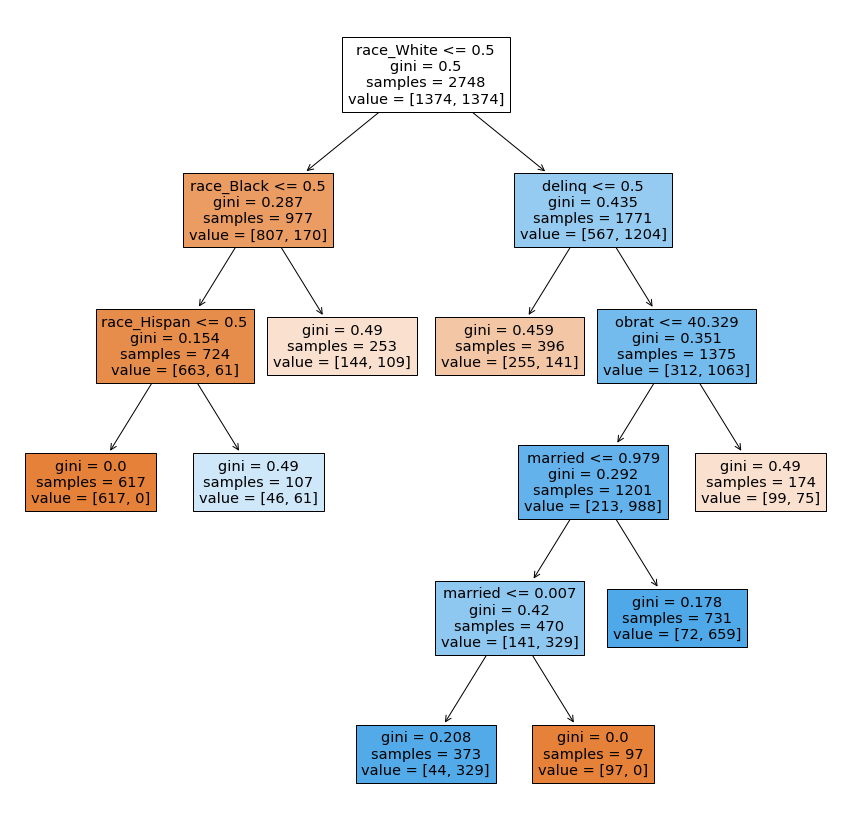

In [354]:
arbre_elag = DecisionTreeClassifier(random_state=0,ccp_alpha=0.0185)
arbre_elag.fit(os_data_X,os_data_y)
plt.figure(figsize=(15,15))
plot_tree(arbre_elag,feature_names = list(os_data_X.columns),filled=True) 
plt.show()

Une fois encore les résultats obetenus en terme de variable selectionnées ne correspond pas a ce qu'on l'on aurait pu penser. En effet, la première variable retenue est **race_white**, cela signifie que c'est celle qui classifie le mieux la population a qui on octroi ou non le crédit. Au total, nous avons 8 feuilles donc 8 régles de décision dont 3 qui ne sont calculées que grâce à la couleur de peau des individus.

Ainsi, il n'y a que si le demandeur de crédit est blanc que l'algorithme retient les variables **delinq**, **obrat** et **married**. C'est-à-dire si la personne à déjà eu des non-remboursements de crédit à la consommation, le pourcentage de ses dépense par rapport a son revenus et s'il est marrié.


### Prédiction - Étude des performances de prédiction

In [355]:
y_pred_arbre = arbre_elag.predict(test_X)
y_pred_arbre_proba = arbre_elag.predict_proba(test_X)

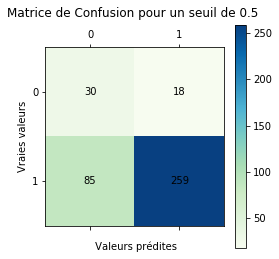

In [405]:
make_cf(test_y, y_pred_arbre)

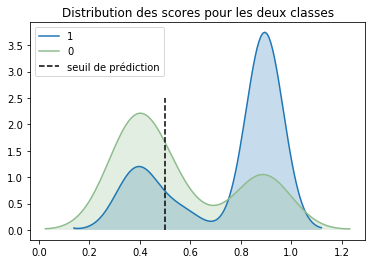

In [410]:
make_density_proba(y_pred_arbre_proba[:,1],y_pred_arbre)

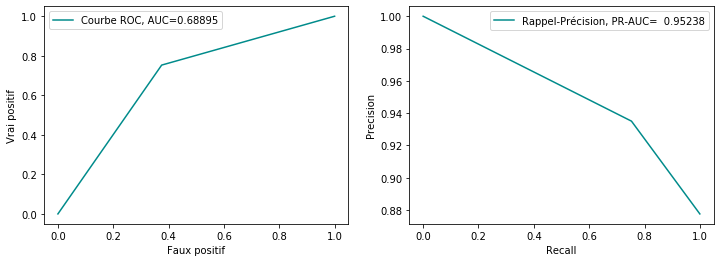

In [414]:
make_roc_pr(y_pred_arbre)  

## 3. Fôrets aléatoires

La méthode utilisée précédemment est très bonne, mais l'arbre obtenu n'est pas optimal. En effet, rien ne dit que l'on n’aurait pas pu obtenir un bien meilleur arbre si nous n'avions pas varié l'ordre de la prise des décisions. Théoriquement, rien ne prouve que l'ordre dans lesquelles les décisions ont été prises est le meilleur parmi tous les ordres qu'il est possible de choisir.

Pour résoudre cet inconvénient, nous utilisons les forêts aléatoires. Il s'agit de construire plusieurs arbres de décision et de tous les entraîner, pour finir par prendre la décision que tous ou du moins que la majorité considérera comme la meilleure.
En entrainant plusieurs arbres de décision plutôt qu'un seul, on sera bien plus à même de prendre une meilleure décision pour résoudre le problème. 

Nous pouvons alors nous demander : comment déterminer le nombre optimal d'arbres pour notre forêt aléatoire ? Nous pourrions penser que plus l'on agmente le nombre d'arbres présents dans la forêt et plus il y a de chance que cette dernière converge vers la solution optimale du problème que l'on cherche à résoudre. Cependant, plus nous mettons d'arbres dans notre forêt, et plus le temps de calcul sera long. Nous décidons alors de tester le score de prédiction de plusieur forêts différentes, allant de 10 à 500 arbres, et en fixant le caractère aléatoire. Nous garderons la forêt avec le meilleur score de prédiction.

0.8673469387755102

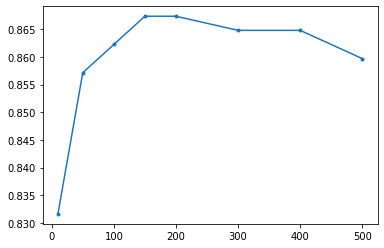

In [370]:
v = [10, 50, 100, 150, 200, 300, 400, 500]
result = []
for i in v :
    clf = RandomForestClassifier(n_estimators=i, random_state=5)
    clf = clf.fit(os_data_X,os_data_y)
    y_pred = clf.predict(test_X)
    score_forest = clf.score(test_X,test_y)
    result.append(score_forest)
plt.plot(v, result, '.-')
np.interp(150, v, result)

In [371]:
# On choisit la forêt avec 150 arbres
clf_150 = RandomForestClassifier(n_estimators=150, random_state=5)
clf_150 = clf_150.fit(os_data_X,os_data_y)
y_pred_150 = clf_150.predict(test_X)
score_forest_150 = clf_150.score(test_X,test_y)
print(score_forest_150)

0.8673469387755102


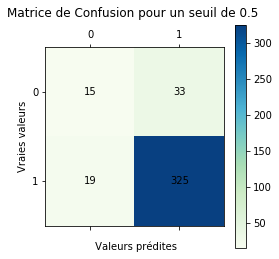

In [406]:
make_cf(test_y, y_pred_150)

In [374]:
prob_pred_f = clf_150.predict_proba(test_X)[::,1]

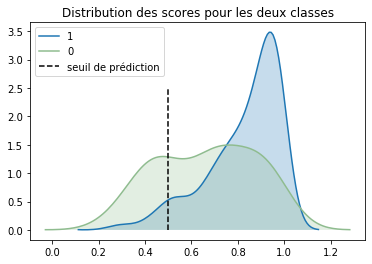

In [411]:
make_density_proba(prob_pred_f,y_pred_150)

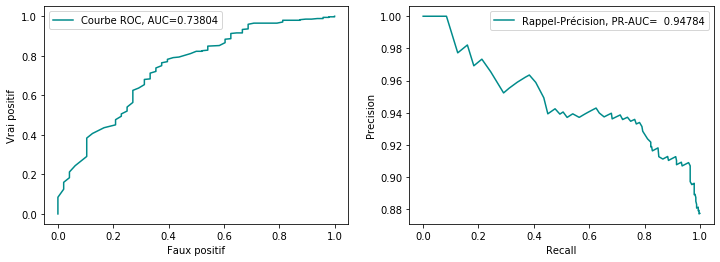

In [415]:
make_roc_pr(prob_pred_f)  

## 7. Résumé des résultats - Conclusion

Pour rappel nous avons choisi de tenir compte de l'AUC et du PR AUC car ces métriques permettent de faire des comparaison entre méthodes sans tenir compte des seuil de prédiction retenu. En effet, pour chaque méthode que nous avons utilisé le seuil retenus était de 0.5. Or, il est clair que pour chacune d'entre elles les résultats aurait pu être améliorer par une variation de ce seuil.

De même, la définition de ce seuil dépend de la cible que nous voulons privilégie, c'est-à-dire les vrais positifs ou les vrais négatifs. Par exemple, dans le domaine médical il faut privilégier la cible des vrais positifs et en ce sens les résultats obtenus par la PR-AUC car son calcul se fait en prenant compte la cible de vrais positifs. À l'inverse dans le domaine du marketing par exemple la présence de faux négatif est considérée comme moins grave que dans le domaine médical. Ainsi, dans ce cas là c'est l'AUC qu'il faut prendre en compte pour choisir la meilleure méthode. 

In [402]:
performance = {'modèle':["Régression logisitique","Arbre de décision", "Forêt aléatoire"],'AUC':[r_auc_reg,r_auc_arbre,r_auc_foret],'PR-AUC':[lr_auc_reg, lr_auc_arbre,lr_auc_foret]}
performance=pd.DataFrame(data=performance)
performance

,modèle,AUC,PR-AUC
0,Régression logisitique,0.732740,0.933175
1,Arbre de décision,0.688953,0.952381
2,Forêt aléatoire,0.738039,0.947840


Comme on peut le voir dans le tableau récapitulatif ci-dessus l'algorithme de l'arbre de décision est celui qui a le plus de mal à repérer les individus a qui ont accorde un prêt immobilier. La régression logistique et les forêts aléatoires performent de façon relativement similaire, mais ce sont les forêt aléatoire qui sont le plus éfficace selon ce critère. 

À l'inverse, pour la répérer les personnes a qui on accorde les crédit les arbres de décision sont meilleurs en termet de Rappel-Précison, suivis des forêts aléatoire.

Il arrive donc le moment de ce demander qu'elle est le critère privilegié. Dans le domaine bancaire, il est plus risqué d'accorder un crédit à une personne qui ne pourra pas honnoré son crédit que l'inverse. Ainsi, mieux repérer les vrais négatifs. De ce fait, nous privilégions les résultats obtenus pas l'AUC. Le modèle le plus formant sur nos données est la fôret aléatoire, puis la régression logistique. 

Cependant, la portée de notre étude ne se restreint pas à la découverte de ses méthode de classification supervisée ou comparaison de ces méthodes. En effet, il est important pour nous de conclure ce travail en apportant des réponses a notre problématique initale. À la question "Existe-t-il des discriminations sur le marché de l'octroi de crédit immobilier ?", nous répondons que d'après les informations contenues dans notre base de données, il semblerait que l'éthnie du demandeur a une influence sur l'octroit ou non d'un prêt immobilier. En effet, la factorielle **race** est constament retenues dans nos modèles et la mesure de son influence dans la prédiction de la variable **approve** est forte.